In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
import cvxpy as cp
from sklearn.cluster import AgglomerativeClustering

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 13 09:39:32 PM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 13 09:39:32 PM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

[**********************95%*********************  ]  480 of 504 completed

In [3]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)
pd.set_option('display.max_rows', 20 )
SP_Close

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,44.221344,0.854541,3.025873,18.250000,9.347848,16.274673,29.907148,6.713820,25.847570,8.052903,...,44.580296,1.278264,5.451857,12.421491,7.525560,19.466265,6.885552,4.861753,25.027779,39.500340
2000-01-04,40.843323,0.782495,2.819287,17.812500,9.080763,14.909401,28.394154,6.643886,25.847570,7.660817,...,42.912193,1.238932,5.508176,11.954849,7.698848,19.093410,6.885552,4.764031,24.666668,37.587597
2000-01-05,38.309807,0.793945,3.038025,18.000000,9.064075,15.204173,28.808693,6.538981,25.599020,7.178246,...,42.036438,1.219267,5.485648,12.588150,7.995915,20.134300,7.004584,4.788458,25.138889,37.543118
2000-01-06,36.851120,0.725238,3.268915,18.031250,9.381234,15.328290,28.021109,6.573947,25.940765,6.740915,...,42.495178,1.290064,5.429327,13.176997,7.921646,21.175198,7.013742,4.747740,23.777779,38.076908
2000-01-07,39.922039,0.759592,3.694239,17.937500,9.481387,16.072983,28.808693,6.678850,26.531031,7.540174,...,45.706287,1.270397,5.485648,12.743693,7.921646,21.113054,6.995429,4.641874,23.513889,38.165886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.282715,179.836319,131.471329,357.829987,140.403183,577.679993,175.470001,65.720932,245.068527,284.299988,...,139.709839,54.160683,465.444122,38.111694,66.820000,61.211414,55.950001,137.372253,606.330017,63.009998
2021-12-28,158.721420,178.799164,131.929840,357.440002,139.420578,569.359985,174.380005,66.576385,244.849625,282.769989,...,141.714767,54.566757,464.425049,38.303886,67.620003,61.013607,56.029999,137.342392,597.320007,63.110001
2021-12-29,160.187180,178.888916,132.906647,361.839996,140.135193,569.289978,175.520004,66.655968,246.779999,282.570007,...,141.645309,54.932884,467.542084,39.091873,67.959999,60.479530,56.650002,138.019257,601.119995,63.450001


## Testing Initial Portfolio without Bayes

In [5]:
five_year_data=SP_Close[:1265] #5 years of data
five_year_data.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-07,13.948145,1.057321,11.317924,14.29,15.050687,29.384233,23.723516,14.685469,22.294920,34.282318,...,37.189411,6.975883,10.584785,13.893994,9.161913,28.189121,24.590631,12.140266,53.099998,50.710098
2005-01-10,13.880588,1.052894,11.317924,14.42,15.196445,29.404230,23.630089,14.806501,22.310619,34.222351,...,37.003433,7.007392,10.730643,13.951576,9.288142,28.296705,25.142307,12.142887,53.840000,50.741310
2005-01-11,13.641055,0.985713,11.345290,14.31,14.917621,29.054298,23.409874,14.598050,22.352488,32.373302,...,36.913887,7.011895,10.605625,13.819959,9.319695,28.223108,25.142307,12.182178,51.669998,50.772518
2005-01-12,13.622633,0.999455,11.349196,14.17,14.952656,29.484215,23.730200,14.503922,22.148375,31.953520,...,37.251392,7.058411,10.684798,13.782943,9.309179,28.642061,25.056398,12.085063,50.910000,50.296547
2005-01-13,13.333962,1.065719,11.161542,12.45,14.665904,29.104290,23.423223,14.692199,21.719215,31.763618,...,36.948315,7.074915,10.605625,13.686282,9.398587,28.619404,24.789597,11.911815,51.060001,49.711346


In [6]:
mu = mean_historical_return(five_year_data)
S = CovarianceShrinkage(five_year_data).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
#ef.save_weights_to_file("weights.txt")  # saves to file
print(ef.portfolio_performance(verbose=True))

Expected annual return: 44.8%
Annual volatility: 13.6%
Sharpe Ratio: 3.16
(0.44758430173544017, 0.13552071771520297, 3.1551212902665506)


## Look at some correlations and clustering to gather ideas

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 864x576 with 0 Axes>

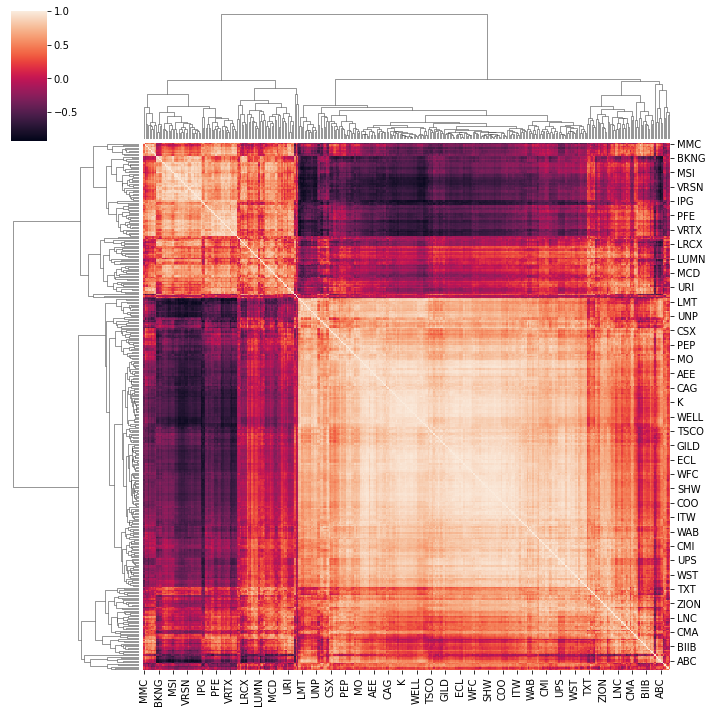

In [7]:
corr = five_year_data.corr()
plt.figure(figsize=(12,8))
sns.clustermap(corr)

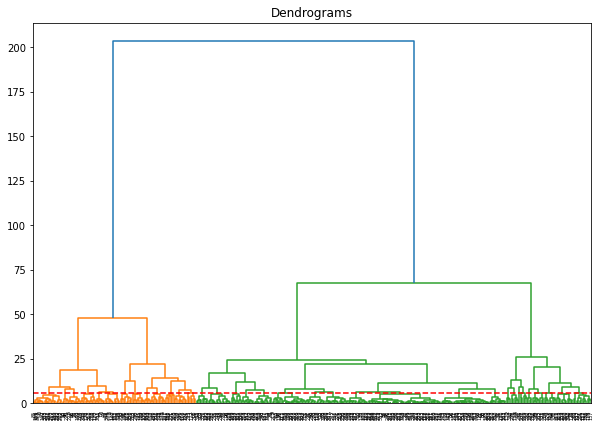

In [9]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(corr, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

In [10]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=4)  
kclusters = cluster.fit_predict(corr)
stock_clusters=pd.DataFrame(SP_Close.columns.values)
stock_clusters=stock_clusters.set_index(0)
stock_clusters['cluster']=kclusters
print(stock_clusters['cluster'].max())

63


(array([ 8.,  3., 18.,  8.,  6., 15.,  8.,  2.,  7.,  5.,  5., 11.,  5.,
        11.,  2.,  3., 18.,  4.,  2., 12.,  7.,  3.,  5.,  4.,  2.,  3.,
         4., 32.,  2.,  2., 23.,  6.,  5.,  2.,  3.,  4.,  5.,  6.,  3.,
         5.,  4.,  1.,  6.,  4.,  3.,  3.,  1.,  4.,  2.,  2.,  1.,  2.,
        19.,  1.,  4.,  4.,  2.,  2.,  3.,  2.,  4.,  2., 12.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.]),
 <BarContainer object of 63 artists>)

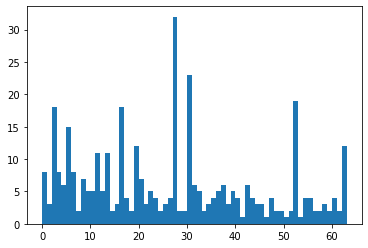

In [15]:
plt.hist(stock_clusters,bins=stock_clusters['cluster'].max())

In [11]:
#shrinkage
def calculate_posterior_mean(like_pop, prior_pop): #for returns use geo mean then multiply by 252 to annualize at end
    w0 = prior_pop.std()
    mu0 = prior_pop.mean() - w0**2/2
    w = like_pop.std()
    dbar = like_pop.mean() - w**2/2

    # Prior:
    prior = stats.norm(mu0, w0)
    
    # Likelihood:
    like = stats.norm(dbar, w)
    
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s * 252

## Markowitz Rebalancer

In [12]:
def Markowits_Bayes_Rebalance(securities_vector, rebalance_period,prior_period,update_period=0,verbose=True,weight_bounds=(-.01,.1)):
    #Bayesian update not yet implemented
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
            
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [13]:
monthly_vanilla_markowitz = Markowits_Bayes_Rebalance(SP_Close,21,252*5,verbose=False) #monthly rebalance with 5 year matrix

In [14]:
def Portfolio_backtest(weight_vector) :
    return_frame = SP_Close.loc[weight_vector.index]
    return_frame = np.exp(np.log(return_frame).diff())-1
    weighted_returns=weight_vector.shift(1)*return_frame
    port_returns = np.sum(weighted_returns, axis=1) #shift so that we are using the weights we had over that period rather than the ones we found with hindsight
    total_return=(port_returns+1).cumprod()
    total_return.plot()
    plt.title('Cumulative Return')

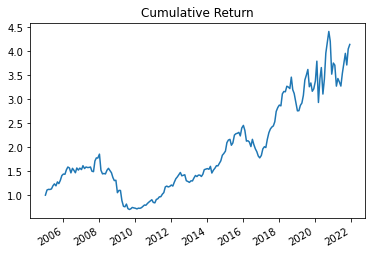

In [15]:
Portfolio_backtest(monthly_vanilla_markowitz)

## Implement Clustering Influenced Dynamic Constraints

In [16]:
def Cluster_Constraints(clusters,u_coef,l_coef): # weight coef for how overweight you can go
    cluster_list = set(clusters.cluster)
    cluster_map = dict(zip(clusters.index,clusters.cluster))
    cluster_totals=[clusters.value_counts()[x] for x in cluster_list]
    cluster_pct=np.array(cluster_totals)/len(clusters)
    cluster_upper_l = dict(zip(cluster_list, cluster_pct*u_coef))
    cluster_lower_l = dict(zip(cluster_list, - l_coef*cluster_pct))
    return cluster_map, cluster_upper_l, cluster_lower_l

In [17]:
#for testing preset clusters
def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh) 
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

In [18]:
class constrained_clusterings_precomputed:
    
    def __init__(self,lookback):
        llist = [1,2,3,4,5]
        if (int(lookback) != lookback) or (int(lookback) not in llist):
            raise ValueError("Only lookback periods of",llist,"supported")
            
        self.df = pd.read_pickle(str(int(lookback))+'.pkl')
        self.names_df = pd.read_pickle('names.pkl')
        
#         corr_threshold = 0.7
#         pct_threshold = 0.1
#         date = datetime.strptime('3-31-2030','%m-%d-%Y')
        
            
    def calcthresholds(self,corr_threshold,pct_threshold,date,DEBUG=False):
        if date < min(self.df.index):
            raise ValueError("Date must be >=",min(self.df.index))
        if date > max(self.df.index):
            print("WARNING: USING",max(self.df.index),"FOR INPUT DATE",date)
        inddate = max(self.df.index[self.df.index <= date])
#         print(inddate)
#         print(self.df.loc[inddate])
        if DEBUG:
            print("DEBUG: USING",inddate,"FOR INPUT DATE",date)
        
        clusters = self.df.loc[inddate]['Clusters']
        numstocks = self.df.loc[inddate]['Numstocks']
        internals = self.df.loc[inddate]['Corrs']
        sz = clusters.shape[0]
        
        tmp = np.sum((internals<corr_threshold)*(numstocks/sz),axis=1)<pct_threshold
        ret = (np.arange(0,sz)+1)[tmp]
        if ret.shape[0] <= 0:
            return None
        OPTIMAL_NUMBER_OF_CLUSTERS = ret[0]
        if DEBUG:
            print("DEBUG: OPTIMAL NUMBER OF CLUSTERS:",OPTIMAL_NUMBER_OF_CLUSTERS)
        
        ret_df = self.names_df
        ret_df = ret_df.set_index(0)
        ret_df['cluster'] = clusters[OPTIMAL_NUMBER_OF_CLUSTERS-1,:].astype(int)
        
#         print(OPTIMAL_NUMBER_OF_CLUSTERS)
#         print(ret_df)
        return ret_df

In [19]:
import os
filelist = ['1.pkl','2.pkl','3.pkl','4.pkl','5.pkl','names.pkl']
for file in filelist:
    if not os.path.exists(file):
        raise ValueError("All of",filelist,"must be present")
        
look1 = constrained_clusterings_precomputed(1)
look2 = constrained_clusterings_precomputed(2)
look3 = constrained_clusterings_precomputed(3)
look4 = constrained_clusterings_precomputed(4)
look5 = constrained_clusterings_precomputed(5)

In [20]:
def get_clusters_precomputed(lookback,corr_threshold,pct_threshold,date,DEBUG=False):
    llist = [1,2,3,4,5]
    if (int(lookback) != lookback) or (int(lookback) not in llist):
        raise ValueError("Only lookback periods of",llist,"supported")
        
    # Apparently pattern matching wasn't implemented until Python 3.10
    if lookback == 1:
        return look1.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 2:
        return look2.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 3:
        return look3.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 4:
        return look4.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 5:
        return look5.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    else:
        raise ValueError("Something went wrong")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [72]:
def Markowits_Bayes_Cluster_Rebalance(securities_vector, rebalance_period=21,prior_period = 253*5, update_period=0,
                                      verbose=True,weight_bounds=(-.01,.1), cluster_u_coef=1.25, cluster_l_coef=.5,
                                      corr_thresh = .75,leave_out_pct = .1, clust_num = None):
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    cluster_list=[]
    num=clust_num
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        update_vector = securities_vector[prior_period+p-update_period:prior_period+p]
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
        
        if clust_num == None:
            clusters= get_clusters_precomputed(prior_period/253,corr_thresh, leave_out_pct, date=prior_vector.index[-1])
            num = clusters.max().values[0]
            cluster_list.append(max(clusters))    
        else:
            clusters = get_clusters(prior_vector.corr(), cluster_number = clust_num)
            cluster_list.append(clust_num) 
        c_map, c_upper, c_lower = Cluster_Constraints(clusters,cluster_u_coef,cluster_l_coef)
        mu = mean_historical_return(prior_vector)  
        if update_period != 0:
            for i in range(num):
                stocksNcluster = clusters.loc[clusters['cluster']==i].index
                for stock in stocksNcluster:
                    print(update_vector[stocksNcluster])
                    mu.loc[stock] = calculate_posterior_mean(prior_vector[stock].pct_change().dropna().to_numpy(),
                                                             update_vector[stocksNcluster].pct_change().dropna().to_numpy())
        
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        ef.add_sector_constraints(c_map, c_lower, c_upper)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    cluster_ts=pd.DataFrame(cluster_list)
    cluster_ts.index=dates
    cluster_ts.columns = ['Clusters']
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df, cluster_ts

In [82]:
SP_Close.columns[SP_Close.columns.str.endswith('L')]

Index(['AAPL', 'AFL', 'ALL', 'BALL', 'CCL', 'CL', 'ECL', 'EL', 'GL', 'HAL',
       'HRL', 'L', 'NWL', 'ODFL', 'ORCL', 'POOL', 'PPL', 'RCL', 'RL', 'ROL',
       'TYL', 'WELL', 'XEL'],
      dtype='object')

In [76]:
SP_Close.loc[:,'BLL']

KeyError: 'BLL'

## Hyperparameter tuning

In [42]:
#cluster_constrained_markowitz_set_num, _ = Markowits_Bayes_Cluster_Rebalance(SP_Close,21,252*5,verbose=False,clust_num=40)
#Portfolio_backtest(cluster_constrained_markowitz_set_num)

In [62]:
import itertools
import random
#add stock thresh list
def random_grid_search(securities_vec, number_of_samples = 50, 
                       rebal_prd_list = [21,63,253],
                       prior_prd_list = [253,2*253,5*253],
                       update_prd_list = [21,63, 253],
                       low_stk_bound_list = [-.007, -.005, -.001],
                       up_stk_bound_list = [.01,.02,.05,.1],
                       cluster_u_coef_list = [2,3,5],
                       cluster_l_coef_list = [-.02, -.05, -.1],
                       corr_thesh_list = [.5,.6,.7,.8],
                       stock_tresh_list = [.05] ):

        
    permutations = []
    df = pd.DataFrame()
    for rebal,prior,update,lstk,ustk,clu,cll,corr,stock in itertools.product(rebal_prd_list, prior_prd_list, update_prd_list, low_stk_bound_list, \
                                                    up_stk_bound_list,cluster_u_coef_list, cluster_l_coef_list, corr_thesh_list, stock_tresh_list):
        if update_prd_list >= rebal_prd_list:
            permutations.append((rebal,prior,update,lstk,ustk,clu,cll,corr,stock))
    list_of_tuples = random.sample(permutations, number_of_samples)
    
    for tuuple in list_of_tuples:
        #print(tuuple)
        weights,_ = Markowits_Bayes_Cluster_Rebalance(securities_vec, rebalance_period=tuuple[0],prior_period = tuuple[1],update_period=tuuple[2],\
                                      verbose=False, weight_bounds=(tuuple[3],tuuple[4]), cluster_u_coef=tuuple[5], cluster_l_coef=tuuple[6],\
                                          corr_thresh = tuuple[7], leave_out_pct = tuuple[8], clust_num = None)
    performance_series = Portfolio_backtest(weights)
    df = df.concat(performance_series)
    return df

In [73]:
random_grid_search(SP_Close[:-1006],number_of_samples=2)

Date
2000-01-03    14.423056
2000-01-04    14.545283
2000-01-05    14.636956
2000-01-06    14.636956
2000-01-07    14.759192
                ...    
2000-12-26    17.890585
2000-12-27    18.993429
2000-12-28    19.330414
2000-12-29    19.544853
2001-01-02    19.575485
Name: COO, Length: 253, dtype: float64
                  COO       CTAS      CTRA        ECL        GIS        IEX  \
Date                                                                          
2000-12-01  16.042459  38.075607  1.158807  16.855188  10.708419  10.697551   
2000-12-04  15.736302  37.359898  1.198652  17.050060  10.741268  10.859025   
2000-12-05  16.011845  38.123325  1.201972  16.635979  10.593453  11.545281   
2000-12-06  16.011845  36.691910  1.185370  16.319340  10.379935  10.677367   
2000-12-07  15.644459  36.978199  1.238496  16.246260  10.511333  10.536076   
...               ...        ...       ...        ...        ...        ...   
2000-12-26  17.890585  40.890736  1.577173  16.174849  11.49

KeyError: "['BLL'] not in index"

## Make the ability to short stocks very minimal

In [97]:
returns_1, _ = Markowits_Bayes_Cluster_Rebalance(SP_Close,21,252*5, weight_bounds=(-.001,.2), cluster_u_coef=2, cluster_l_coef=.01,clust_num=50,verbose=False)

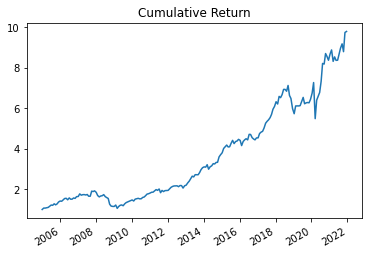

In [98]:
Portfolio_backtest(returns_1)

## Use Shrinkage on Clusters!

In [99]:
SP_Pre2018= SP_Close[:'2018-01-01']
SP_Pre2018.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,65.136894,41.969559,86.004715,191.639999,53.128281,175.000000,81.833572,35.416149,108.417572,103.889999,...,91.037071,27.875200,97.919571,29.092243,43.322823,66.389336,63.901493,76.503883,105.150002,46.593800
2017-12-26,65.040184,40.904797,86.739548,189.539993,53.193611,174.440002,81.630951,35.477825,109.057610,103.800003,...,91.917725,27.875200,97.575256,29.192158,42.945709,66.397255,64.328659,76.308914,104.790001,46.167164
2017-12-27,65.088531,40.911991,86.134926,190.419998,53.632221,175.360001,82.063835,35.460217,108.770058,104.580002,...,92.010406,27.938107,97.772003,29.225466,43.244251,66.333984,64.105347,76.503883,104.949997,46.031006
2017-12-28,65.233597,41.027103,86.125626,190.550003,53.622890,175.550003,82.321724,35.486645,108.816437,105.070000,...,92.140182,28.217251,97.408043,29.358679,43.497570,66.428864,64.579773,76.754570,104.279999,46.602879
2017-12-29,64.912766,40.583443,85.409386,187.410004,53.258942,175.240005,81.999359,35.319218,108.705132,104.830002,...,91.537659,28.170069,97.063744,29.358679,43.524696,66.128410,63.996483,75.770409,103.800003,46.139935


In [100]:
#3 month
returns_2, _ = Markowits_Bayes_Cluster_Rebalance(SP_Pre2018,63,252*5,63,weight_bounds=(-.001,.2), cluster_u_coef=2, cluster_l_coef=-.01,clust_num=50)

Iteration 1 of 52
2000-01-03 00:00:00 - 2005-01-06 00:00:00
Iteration 40 of 52
2000-04-03 00:00:00 - 2005-04-08 00:00:00
Iteration 40 of 52
2000-07-03 00:00:00 - 2005-07-08 00:00:00
Iteration 40 of 52
2000-10-02 00:00:00 - 2005-10-06 00:00:00
Iteration 40 of 52
2001-01-02 00:00:00 - 2006-01-06 00:00:00
Iteration 40 of 52
2001-04-03 00:00:00 - 2006-04-07 00:00:00
Iteration 40 of 52
2001-07-03 00:00:00 - 2006-07-10 00:00:00
Iteration 40 of 52
2001-10-08 00:00:00 - 2006-10-06 00:00:00
Iteration 40 of 52
2002-01-08 00:00:00 - 2007-01-09 00:00:00
Iteration 40 of 52
2002-04-10 00:00:00 - 2007-04-11 00:00:00
Iteration 40 of 52
2002-07-10 00:00:00 - 2007-07-11 00:00:00
Iteration 40 of 52
2002-10-08 00:00:00 - 2007-10-09 00:00:00
Iteration 40 of 52
2003-01-08 00:00:00 - 2008-01-09 00:00:00
Iteration 40 of 52
2003-04-09 00:00:00 - 2008-04-10 00:00:00
Iteration 40 of 52
2003-07-10 00:00:00 - 2008-07-10 00:00:00
Iteration 40 of 52
2003-10-08 00:00:00 - 2008-10-08 00:00:00
Iteration 40 of 52
2004-0

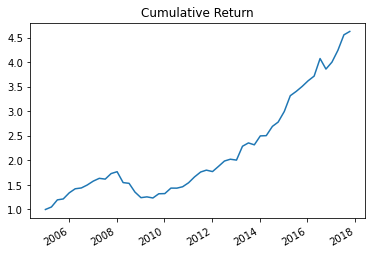

In [101]:
Portfolio_backtest(returns_2)